In [13]:
import numpy as np
import datetime

from os import listdir
from os.path import isfile, join

import licel as licel
import generic as generic

from us_std import Atmosphere
import rayleigh_scattering as rscat

from scipy import signal
from scipy import integrate
from scipy import stats

import statsmodels.api as sm

import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot

#%matplotlib notebook

In [14]:
def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

def fit(q0,q1,Sn,Sf):
    GCs = np.polyfit(Sn[q0:q1],Sf[q0:q1],1)
#   f = np.poly1d(GCs)
#   an_new = f(Sn[q0:q1])
    return GCs

def get_toggle_freq(an, an_d, pc, overlap, max_freq, min_freq = None, pre_amplifier_range = None, LSB_coeff = None):
#   tmp = np.subtract(an, an_d)
#   an = tmp[0]
    LSB = pre_amplifier_range/2.0**12
    Xa = None
    Xp = None
    min_freq_bin = None

    if min_freq == None and LSB == None:
        warnings.warn('No min_freq or LSB specified.')

    if LSB != None:
        if LSB_coeff == None:
            warnings.warn('LSB_coeff not specified. Using LSB_coeff = 2')
            LSB_coeff = 2.0
        for j in range(overlap, len(an)):
            if an[j] < LSB_coeff * LSB:
               Xa = j - 1
               break

    if min_freq != None:
        for j in range(overlap, len(pc)):
            if pc[j] < min_freq:
               min_freq_bin = j - 1
               break

    if max_freq > 70.0 or max_freq < 10.0:
        warnings.warn('Maximum toggle frerquency values between 10MHz and 70MHz are considered "safe" by Raymetrics')

    if np.amax(pc) > max_freq:
        for j in range(overlap, len(pc)):
            if pc[j] < max_freq:
                Xp = j - 1
                break
    else:
       warnings.warn('Specified maximum toggle frequency is greater than photon counting signal peak.')
    return (Xp, Xa, min_freq_bin)

In [15]:
dates = []

Taud = 4e-09
range_355 = 100.0
range_387 = 20.0
Xa355 = []
Xp355 = []
mfb355 = []
Xa387 = []
Xp387 = []
mfb387 = []
maxf = 10.0
overlap = 60
root_dir = '/home/luka/lidar/2020/08052020'
data_dir = root_dir+'/ray'
dark_dir = root_dir+'/dark'
dark_file = [join(dark_dir, f) for f in listdir(dark_dir) if isfile(join(dark_dir,f))]
#print('dark_file=',dark_file)
dark_measurement = generic.LicelLidarMeasurement(dark_file)
an355d = dark_measurement.channels['00355.o_an'].matrix
ph355d = dark_measurement.channels['00355.o_ph'].matrix
an387d = dark_measurement.channels['00387.o_an'].matrix
ph387d = dark_measurement.channels['00387.o_ph'].matrix

filelist = [join(data_dir,f) for f in listdir(data_dir) if isfile(join(data_dir,f))]
filelist.sort()
#print(filelist,len(filelist))

In [16]:
measurement = generic.LicelLidarMeasurement(filelist)
    
an355 = measurement.channels['00355.o_an'].matrix 
ph355 = measurement.channels['00355.o_ph'].matrix
an387 = measurement.channels['00387.o_an'].matrix
ph387 = measurement.channels['00387.o_ph'].matrix

z = measurement.channels['00355.o_an'].z
valid_time = measurement.info['start_time'] + measurement.info['duration']/2 
dates.append(valid_time)

In [17]:
#Ns = 2.54743E19 #cm-3
Ns = 2.54743E25 #m-3
sigma355 = rscat.scattering_cross_section(355) * 1E-4
sigma387 = rscat.scattering_cross_section(387) * 1E-4
rhon355 = 0.0306
rhon387 = 0.0299

wl = 387
if wl == 355:
    an = an355
    ph = ph355
    an_d = an355d
    sigma = sigma355
    rhon = rhon355
elif wl == 387:
    an = an387
    ph = ph387
    an_d = an387d
    sigma = sigma387
    rhon = rhon387

#dead time correction
nDTC = ph
nDTCa = np.mean(ph, axis = 0)
ph = ph*1000000.0/(1 - (ph*1000000.0*Taud))
ph = ph/1000000.0
#dark subtraction
an = an - an_d
#an387 = an387 - an387d

#gluing region
ana = np.mean(an, axis = 0)
pha = np.mean(ph, axis = 0)

#zero bin and bin shift
ana = np.roll(ana, -7)
pha = np.roll(pha, 2)
#ana = np.roll(ana, -9)
z = np.roll(z,-1)

#analog background correction
background = np.mean(ana[4000:6000])
ana = ana - background
#photon counting background correction
background = np.mean(pha[4000:6000])
pha = pha - background

Xp, Xa, mfb = get_toggle_freq(ana, an_d, pha, overlap, max_freq = 10.0, min_freq = 0.5, pre_amplifier_range = range_355, LSB_coeff = 2.0)
print('Xp, Xa, mfb')
print(Xp, Xa, mfb)

Xp, Xa, mfb
(70, 100, 266)


In [18]:
#=============================GLUE===================================
print('=============================GLUE===================================')
print('correlation coeff.', stats.pearsonr(ana[Xp:Xa],pha[Xp:Xa]))
Xam = int((Xa + Xp) / 2)
slope, intercept, r_value, p_value, std_err = stats.linregress(ana[Xp:Xa],pha[Xp:Xa])
print("r-squared:", r_value**2)
GCs=[]
GCs.append(slope)
GCs.append(intercept)

X = sm.add_constant(ana[Xp:Xa])
Y = pha[Xp:Xa]
linreg = sm.OLS(Y,X).fit()
#print(linreg.params)
b, a = linreg.params
#print(b,a)
#print(linreg.summary())
#LSQF_scaled = linreg.predict(X)
LSQF_scaled = a * ana + b

scaled_an = GCs[0] * ana + GCs[1]

residuals = pha[Xp:Xa] - LSQF_scaled[Xp:Xa]
X = sm.add_constant(z[Xp:Xa])
Y = residuals
#print('residuals====================================')
#print(residuals)
#np.savetxt('residuals.txt',residuals)
#print('residuals====================================')
linreg = sm.OLS(Y,X).fit()
#print(linreg.params)
#print(linreg.summary())
b, a = linreg.params
b_std, a_std = linreg.bse
LSQFR = a * residuals + b
LSQF1 = (a + 2 * a_std) * X[:,1] + (b - 2 * b_std)
LSQF2 = (a - 2 * a_std) * X[:,1] + (b + 2 * b_std)

if Xa - Xp >= 30:
    print('slope test')
    X = sm.add_constant(z[Xp:Xam])
    Y = residuals[:Xam-Xp]
    linreg = sm.OLS(Y,X).fit()
    b, k1 = linreg.params
    b_std, deltak1 = linreg.bse

    X = sm.add_constant(z[Xam:Xa])
    Y = residuals[Xam-Xp:]
    linreg = sm.OLS(Y,X).fit()
    b, k2 = linreg.params
    b_std, deltak2 = linreg.bse
    C = abs(k1 - k2)
    deltaC = np.sqrt(deltak1 **2 + deltak2 **2)
    print(C, 2 * deltaC, C < 2 * deltaC)

if C < 2 * deltaC:
    print('stability test')
    X = sm.add_constant(z[Xp:Xam])
    Y = ana[Xp:Xam]
    linreg = sm.OLS(Y,X).fit()
    b, K1 = linreg.params
    b_std, deltaK1 = linreg.bse
    
    X = sm.add_constant(z[Xam:Xa])
    Y = ana[Xam:Xa]
    linreg = sm.OLS(Y,X).fit()
    b, K2 = linreg.params
    b_std, deltaK2 = linreg.bse
    print(abs(K1 - K1) < np.sqrt(deltaK1 **2 + deltaK2 **2))
#glued = scaled_an
glued = LSQF_scaled
glued[Xp:] = pha[Xp:]
#glued = glued[0:len(hgtRS_int)] * (hgt_tmp[0:len(hgtRS_int)] **2)
glued = glued * z **2

#plt.plot(z[Xp:Xa],residuals,label='residuals')
#plt.plot(z[Xp:Xa],LSQFR,label='LSQFR')
#plt.plot(z[Xp:Xa],LSQF1,label='LSQF1')
#plt.plot(z[Xp:Xa],LSQF2,label='LSQF2')
#plt.legend(loc='upper right')
#plt.show()
print('=============================GLUE===================================')

=============================GLUE===================================
('correlation coeff.', (0.9996243545342318, 2.7215009542263356e-45))
('r-squared:', 0.9992488501779794)
slope test
(2.0676644597460603e-05, 0.0010451369606373833, True)
stability test
True
=============================GLUE===================================


In [19]:
#=========================ARL GDAS================================
data = np.genfromtxt('gdas_profile_200508.txt')
p, hgt, T, U, V, RH, TPOT, WDIR, WSPD = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], data[:,8]
T = T + 273.15

hgt_int = np.linspace(210.0, 30210.0, 4001)
hgt_wt = np.linspace(0.0, 30210.0, 4029)
p_int = np.interp(hgt_int, hgt, p)
T_int = np.interp(hgt_int, hgt, T)
RH_int = np.interp(hgt_int, hgt, RH)
a_mol355 = sigma355 * Ns * (T_int[0] / T_int) * (p_int / p_int[0])
b_mol355 = (a_mol355 / (8.0*np.pi/3.0)) * (2 / (2 + rhon355))
a_mol387 = sigma387 * Ns * (T_int[0] / T_int) * (p_int / p_int[0])
b_mol387 = (a_mol387 / (8.0*np.pi/3.0)) * (2 / (2 + rhon387))

rminm = 9000
rmaxm = 10000
rmin = int((rminm - hgt_int[0]) / 7.5)
rmax = int((rmaxm - hgt_int[0]) / 7.5)
r0 = int((rmin  + rmax ) / 2)
normA = rmin
normB = rmax
print(rmin, rmax, r0)

(1172, 1305, 1238)


In [20]:
print('=============================RAYLEIGH===============================')
#normalized_RCS = glued * integrate.trapz(b_tmp[rmin:rmax]) / integrate.trapz(glued[rmin:rmax])
#ray = normalized_RCS
if wl == 355:
    b_mol = b_mol355
    a_mol = a_mol355
    b_attn = np.zeros(b_mol.shape[0])
    
    for i, value in np.ndenumerate(b_mol):
        r = i[0]
        if r < r0:
            b_attn[r] = b_mol[r] * np.exp(-2 * integrate.trapz(a_mol[r:r0],np.flip(hgt_int[r:r0],0)))
        else:
            b_attn[r] = b_mol[r] * np.exp(-2 * integrate.trapz(a_mol[r0:r],hgt_int[r0:r]))

elif wl == 387:
    b_mol = b_mol387
    a_mol = a_mol387
    b_attn = np.zeros(b_mol.shape[0])
    
    for i, value in np.ndenumerate(b_mol):
        r = i[0]
        if r < r0:
            b_attn[r] = b_mol387[r] * np.exp(-1 * (integrate.trapz(a_mol355[r:r0],np.flip(hgt_int[r:r0],0)) + integrate.trapz(a_mol387[r:r0],np.flip(hgt_int[r:r0],0))))
        else:
            b_attn[r] = b_mol387[r] * np.exp(-1 * (integrate.trapz(a_mol355[r0:r],hgt_int[r0:r]) + integrate.trapz(a_mol387[r0:r],hgt_int[r0:r])))       
            
normalized_RCS2RS = glued * integrate.trapz(b_attn[normA:normB]) / integrate.trapz(glued[normA:normB])
ray = normalized_RCS2RS

#b_attn_RS
ray_mean = np.mean(ray[rmin:rmax])
ray_std = np.std(ray[rmin:rmax], ddof = 1)
ray_SEM = ray_std / np.sqrt(len(ray[rmin:rmax]))
n = len(ray[rmin:rmax])

itemindex = np.where(z == hgt_int[0])
nan = np.empty(itemindex[0][0])
nan[:] = np.NAN
attnRBSC = np.insert(b_attn,0,nan)
#print(np.shape(attnRBSC))
#print(np.shape(glued))

=============================RAYLEIGH===============================


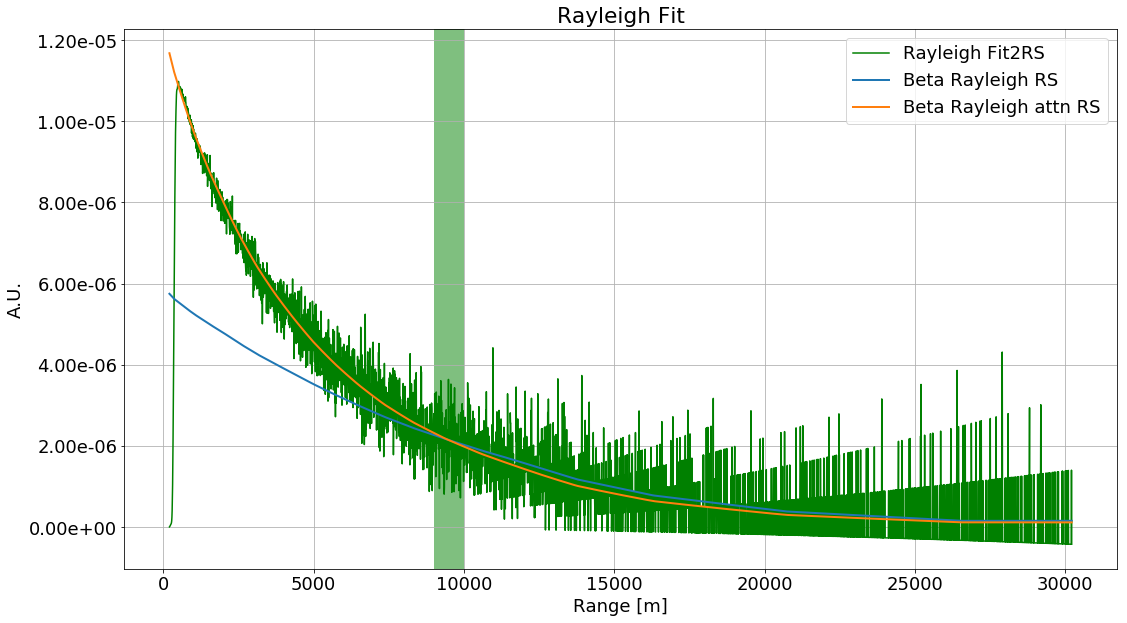

In [21]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

plt.plot(hgt_int, ray[0:len(hgt_int)], label = 'Rayleigh Fit2RS', color='green')
plt.plot(hgt_int, b_mol387[0:len(hgt_int)], label = 'Beta Rayleigh RS', linewidth=2)
plt.plot(hgt_int, b_attn[0:len(hgt_int)], label = 'Beta Rayleigh attn RS', linewidth=2)

plt.grid()

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.axvspan(hgt_int[0] + rmin * 7.5, hgt_int[0] + rmax * 7.5, facecolor='g', alpha=0.5)

plt.legend(loc='upper right')
plt.title('Rayleigh Fit')
plt.xlabel('Range [m]')
plt.ylabel('A.U.')
plt.tight_layout()
plt.show()
#plt.close()

In [22]:
lidar_site = 'station ID = bgd (Belgrade)\n'
lidar_name = 'system = BARLI\n'
channel = 'signal = 0387, glued\n'
date = 'date of measurement, time, duration of measurement = 08.05.2020, 21UTC, 1800s\n'
radiosonde = 'location, WMO radiosonde station ID, date of radiosonde = GDAS profile for Belgrade - Kostutnjak, 13275, 08.05.2020, 21UTC\n'
fit_range = 'lower and upper Rayleigh height limits[km]: ' + str(rminm/1000.0) + ', ' + str(rmaxm/1000.0) + '\n'
columns = 'range, attenuated_RayleighBSC, RangeCorrectedSignal, Dark Measurement'
header = lidar_site + lidar_name + channel + date + radiosonde + fit_range + columns
out_h = hgt_wt[28:]
#out_b = attnRBSC[28:]
out_b = b_attn
out_g = glued[28:len(hgt_wt)]
out_d = an_d[0,28:len(hgt_wt)]
np.savetxt('ray387.txt', np.column_stack((out_h, out_b, out_g, out_d)), fmt='%.15e', header = header, comments='', delimiter=',')

In [27]:
out_d

array([4.95208249, 4.95159408, 4.95242844, ..., 4.95672229, 4.95703432,
       4.95683082])

In [31]:
b_attn_RS

array([1.90292876e-05, 1.89892287e-05, 1.89492611e-05, ...,
       1.54452267e-07, 1.54447960e-07, 1.54443653e-07])

In [32]:
attnRBSC

array([           nan,            nan,            nan, ...,
       1.54452267e-07, 1.54447960e-07, 1.54443653e-07])

In [30]:
hgtRS_int

array([  210. ,   217.5,   225. , ..., 30195. , 30202.5, 30210. ])

In [39]:
attnRBSC[27]

1.90292876468693e-05